In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data_path = '/content/drive/MyDrive/heart/train/train'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
test_data_path = '/content/drive/MyDrive/heart/test/test'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
valid, test = train_test_split(test_df,train_size= 0.5,shuffle=True,random_state=42)

In [ ]:
img_size = (224,224)
batch_size = 16


tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 4438 validated image filenames belonging to 2 classes.
Found 2219 validated image filenames belonging to 2 classes.
Found 2219 validated image filenames belonging to 2 classes.


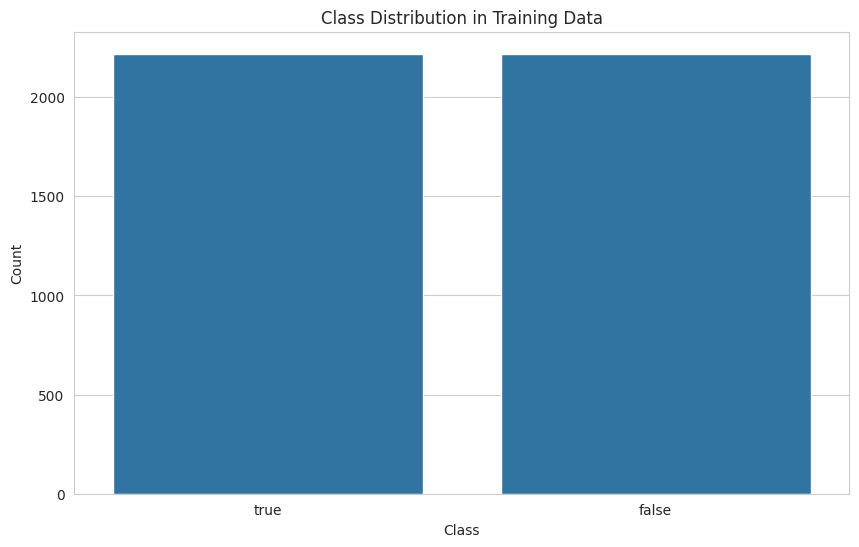

In [ ]:
# Class distribution in training data
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

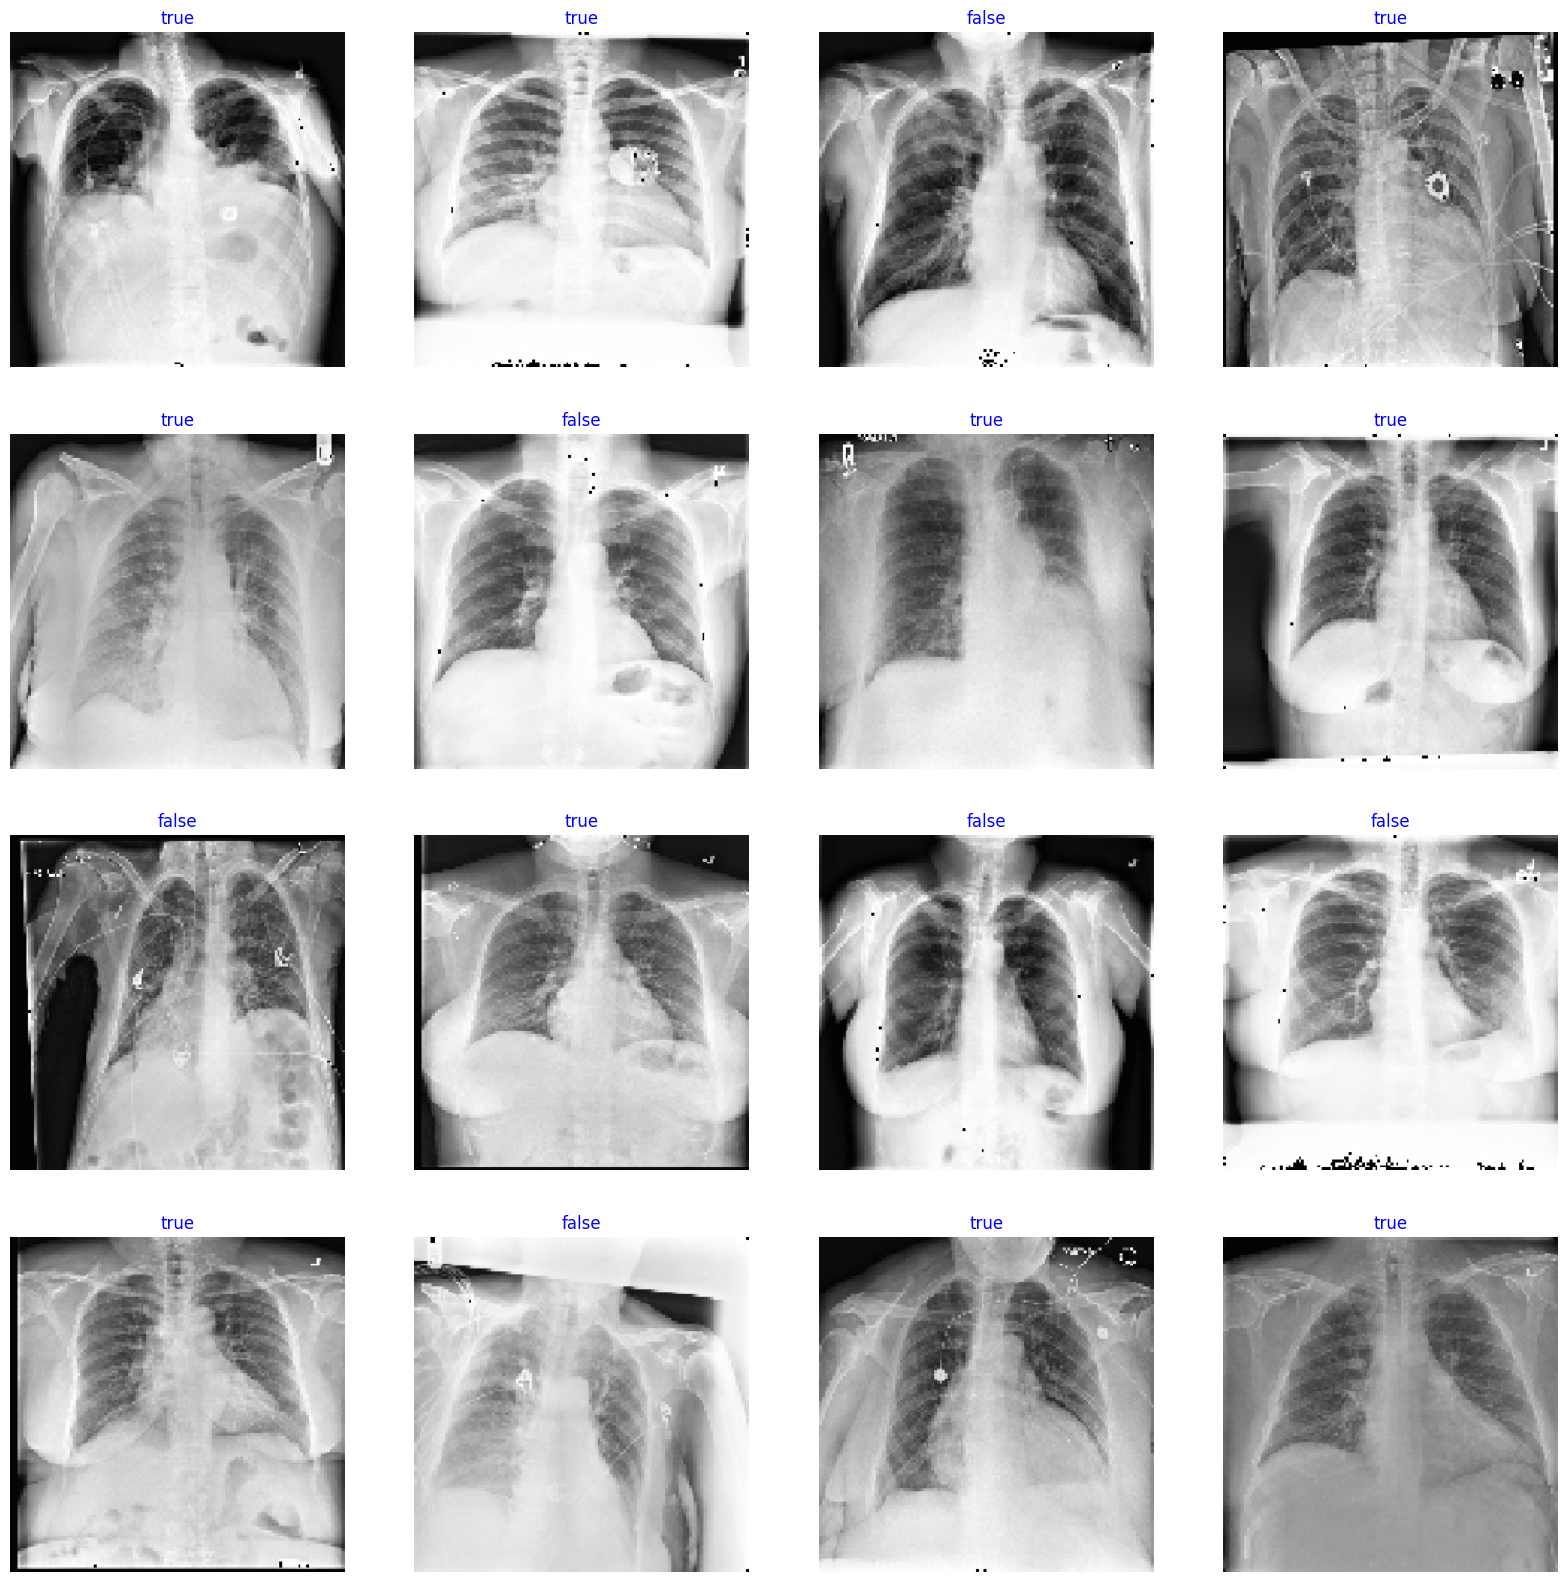

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

Found 4438 images belonging to 2 classes.


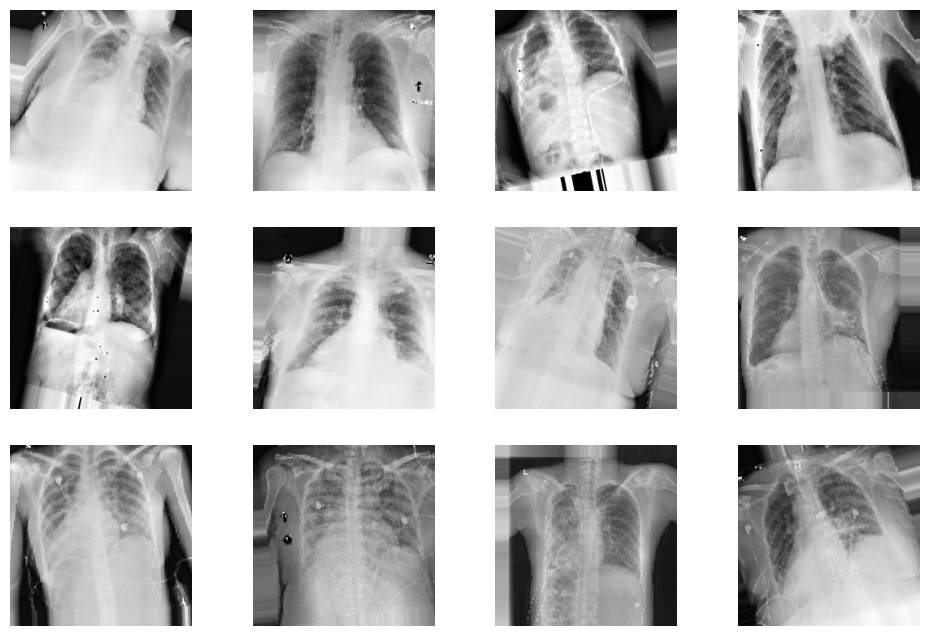

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_size[0], img_size[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

augmented_images, _ = next(train_generator)

plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

In [ ]:
img_shape = (img_size[0],img_size[1],3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                       

In [ ]:
from tensorflow.keras.utils import plot_model

# Define filename for the plot (modify as needed)
plot_path = 'model_architecture.png'

# Generate plot of the model architecture
plot_model(model, to_file=plot_path, show_shapes=True, show_layer_names=True)

print(f"Model architecture saved to: {plot_path}")

In [ ]:
Epochs = 10

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/10
278/278 [==============================] - 1858s 6s/step - loss: 6.7381 - accuracy: 0.6679 - val_loss: 5.0538 - val_accuracy: 0.7603
Epoch 2/10
278/278 [==============================] - 259s 931ms/step - loss: 3.9360 - accuracy: 0.7650 - val_loss: 3.0455 - val_accuracy: 0.8288
Epoch 3/10
278/278 [==============================] - 259s 932ms/step - loss: 2.5732 - accuracy: 0.8197 - val_loss: 1.9117 - val_accuracy: 0.9180
Epoch 4/10
278/278 [==============================] - 259s 932ms/step - loss: 1.6727 - accuracy: 0.8668 - val_loss: 1.2340 - val_accuracy: 0.9662
Epoch 5/10
278/278 [==============================] - 259s 931ms/step - loss: 1.1743 - accuracy: 0.8982 - val_loss: 0.8875 - val_accuracy: 0.9770
Epoch 6/10
278/278 [==============================] - 273s 984ms/step - loss: 0.8040 - accuracy: 0.9241 - val_loss: 0.5593 - val_accuracy: 0.9901
Epoch 7/10
278/278 [==============================] - 256s 920ms/step - loss: 0.5739 - accuracy: 0.9443 - val_loss: 0.4306 - v

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

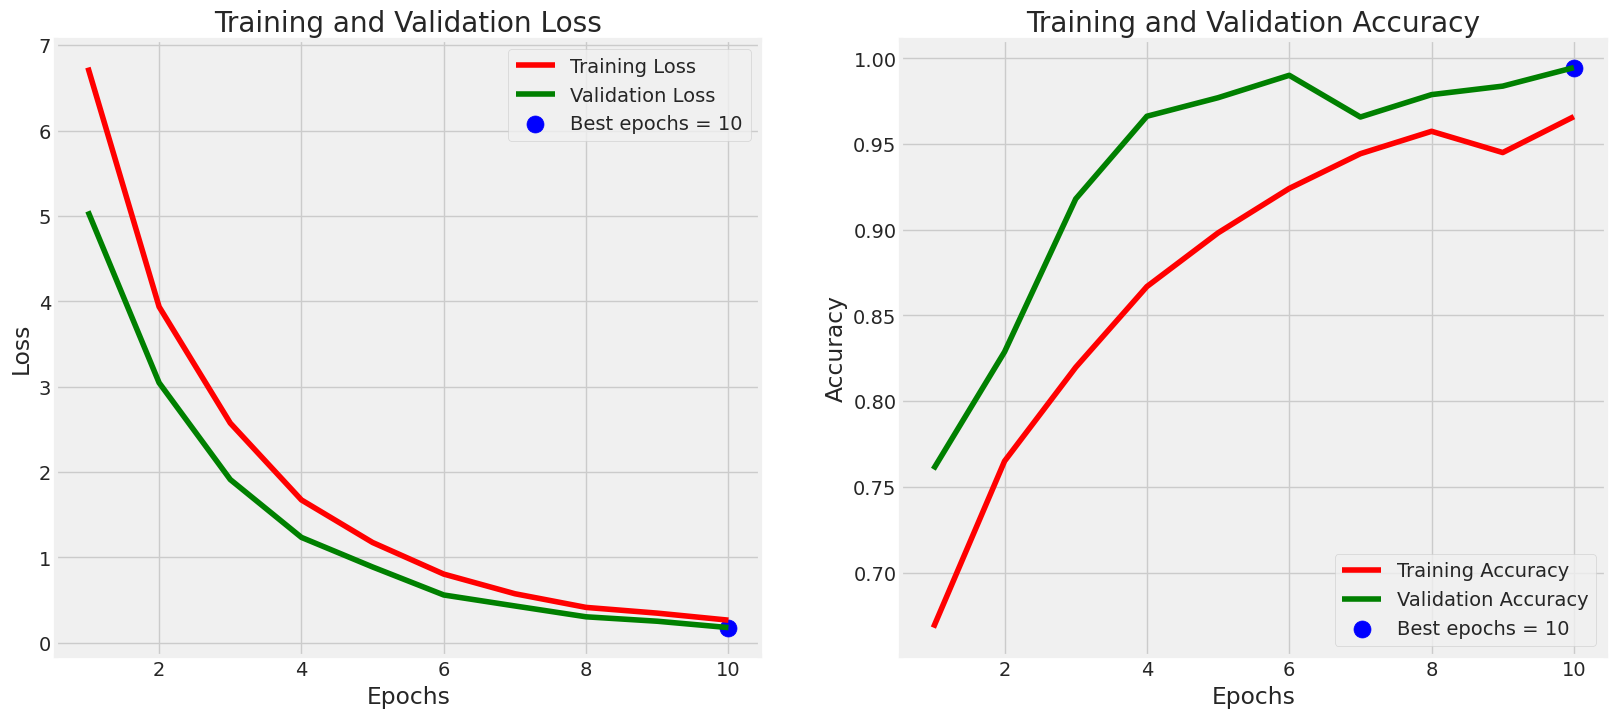

In [ ]:
#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [ ]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 3s 186ms/step - loss: 0.1914 - accuracy: 0.9883
Train Loss:  0.16584491729736328
Train Accuracy:  1.0
--------------------
Validation Loss:  0.18863336741924286
Validation Accuracy:  0.984375
--------------------
Test Loss:  0.19142165780067444
Test Accuracy:  0.98828125


In [ ]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

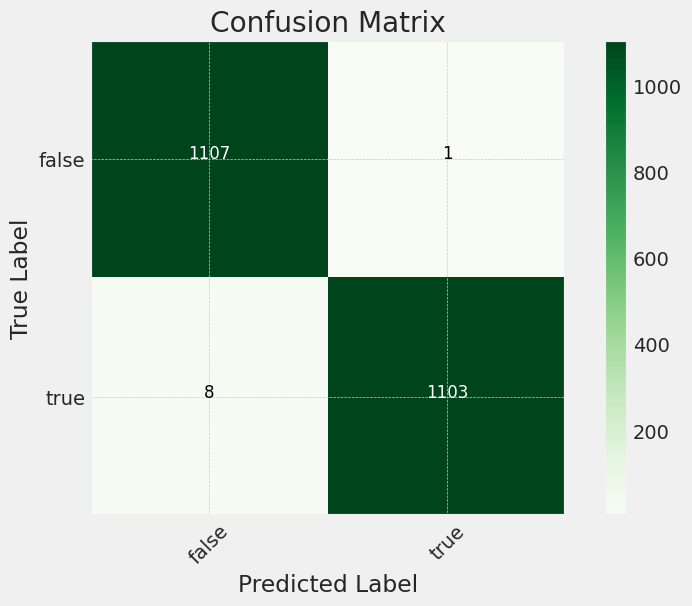

In [ ]:
import matplotlib.pyplot as plt

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(8, 6))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black', fontsize=12)

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

In [ ]:
classes = ["positive", "negative"]
report = classification_report(test_gen.classes, y_pred, target_names=classes)
print(report)

              precision    recall  f1-score   support

    positive       0.99      1.00      1.00      1108
    negative       1.00      0.99      1.00      1111

    accuracy                           1.00      2219
   macro avg       1.00      1.00      1.00      2219
weighted avg       1.00      1.00      1.00      2219



In [ ]:
import ydata_profiling as yp

# Assuming your training DataFrame is named 'train_df'
profile = yp.ProfileReport(train_df, explorative=True)

# Generate HTML report (saved to 'profile_report.html')
profile.to_file("profile_report.html")